## Importing the libraries

In [1]:
from PIL import Image
from io import BytesIO
import webcolors

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from importlib import reload
from mpl_toolkits import mplot3d
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from utils import *

import warnings
warnings.filterwarnings("ignore")

## Settinng the logger

In [2]:
import logging
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
sns.set(style="ticks", color_codes=True)
pd.options.display.float_format = '{:.3f}'.format

## Image Exploration

Each pixel in an image can be represented as three 8-bit unsigned (positive) integers ranging from 0 to 255, or scaled into three unsigned (positive) float ranging from 0 to 1. The three values specify the intensity values of each red, green, blue color, which often called as RGB encoding. In this notebook, we use a 220 by 220 pixels of lena.png, which serve as a standard test image widely used in image processing field.

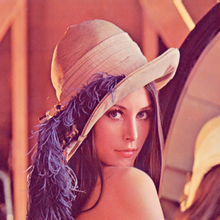

In [3]:
ori_img = Image.open('data/lena.png')
ori_img

In [4]:
X = np.array(ori_img.getdata())
ori_pixels = X.reshape(*ori_img.size, -1)
ori_pixels.shape

(220, 220, 3)

Pixels are stored as a 3D matrix with shape (220, 220, 3). The first two values specify the width and height of the image, the last value specifies the RGB encoding.

In [5]:
ori_img_size = get_image_size(ori_img)
ori_img_size

85.99609375

In [6]:
ori_img_n_colors = len(set(ori_img.getdata()))
ori_img_n_colors

37270

The original image size of lena.png is 86 KB and has 37270 unique colors present in the image.

<img src='data/variance.png'></img>

In [7]:
ori_img_total_variance = sum(np.linalg.norm(X - np.mean(X, axis = 0), axis = 1)**2)
print("Variance==> ",ori_img_total_variance)

Variance==>  302426700.6427498


## KMeans Clustering

K-Means Algorithm is an unsupervised learning algorithm which is employed in partioning a dataset into k cluster wherein k is specified by the user. The aim of the algorithm is to divide the dataset into k cluster where each cluster is a group of similar samples. The algorithm tries best to achieve the following conditions:
1. All the samples inside the same cluster should have high similarity.
2. All the samples within different clusters should have high degree of dissimilarity.

Each cluster is represented by a centroid and k-clusters have k centroids.

#### Working of K-Means Algorithm
Following are the steps that take place in the K-Means Algorithm:
1. User specifies the number of clusters/centroids or k.
2. k different points are selected initially and the selection is totally random.
3. Each of the datapoint on the graph is then assigned to their nearest centroid point.
4. The centroids are then updated by computing the mean of the datapoints in that cluster
5. The above steps i.e. assigning datapoints and updating centroid positions are repeated till convergence i.e. when centroids do not update anymore.


### Implementation of K-Means for Image Compression
The original image comprises of thousands of colors. The project moves to use K-Means Algorithm to reduce the number of the colors. This will ensure that only few RGB values would be stored and eventually making compressing the image.  
Each pixel value would be a dataframe with the color channels viz. Red, Green, Blue being the features.  
For the lena image there will be 220x220 = 48400 samples with 3 features per sample.

#### Visualizing the pixel in first row of the image in a 3-D plot with the color channel values as the axes

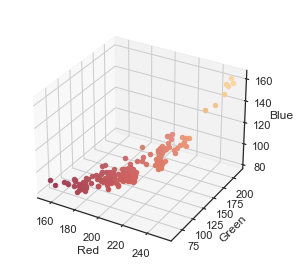

In [8]:
reload(plt)
fig = plt.figure("3-D Plot of Image")
ax = plt.axes(projection='3d')
for px in X[:ori_pixels.shape[0]]:
    ax.scatter3D(*px, c = np.array([px])/255)
ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue")
ax.dist = 11
plt.tight_layout()
plt.show()

### Baseline Model
In the baseline model K-Means algorithm would be applied with k = 2. The aim of the baseline model is just to visualize the process.

In [9]:
kmeans = KMeans(n_clusters = 2,
                n_jobs = -1,
                random_state = 123).fit(X)
kmeans_df = pd.DataFrame(kmeans.cluster_centers_, columns = ['Red', 'Green', 'Blue'])
kmeans_df

,Red,Green,Blue
0,213.718,133.891,124.260
1,130.543,47.389,77.450


Getting the English Name for the Color from RGB values

In [10]:
kmeans_df["Color Name"] = list(map(get_colour_name, np.uint8(kmeans.cluster_centers_)))
kmeans_df

,Red,Green,Blue,Color Name
0,213.718,133.891,124.260,darksalmon
1,130.543,47.389,77.450,brown


K-Means Algorithm gave us 2 centroids. The next step is to replace the pixels in a cluster with their respective centroid values. In this scenario since the clusters are 2, therefore the output image will only have 2 colors only.

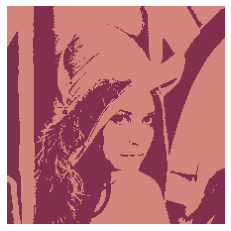

In [11]:
# Replacing Pixels with centroids
new_pixels = replaceWithCentroid(kmeans, ori_img)

# Plotting the image
plotImage(new_pixels, new_pixels.shape).show()

It can be seen from the above image that it has been reconstructed using two colors only viz. brown and darksalmon.

#### Evaluation Metrics
##### Within Cluster Sum of Squares(WCSS)
This measures the sum of squared Euclidean distance of all the points within a cluster to its cluster centroid.

##### Between Cluster Sum of Square(BCSS)
This measures the sum of squared Euclidean distance between all centroids.

##### Explained Variance
This measures how many percents that the compressed image can explain the variance of the original image.  

Explained Variance = (BCSS)/(BCSS+WCSS)

##### Image Size
Image size, measured in kilobytes to evaluate the reduction/compression performance.

In [12]:
WCSS = kmeans.inertia_
BCSS = calculateBCSS(X, kmeans)
exp_var = 100*BCSS/(WCSS + BCSS)
print("WCSS: {}".format(WCSS))
print("BCSS: {}".format(BCSS))
print("Explained Variance: {:.3f}%".format(exp_var))
print("Image Size: {:.3f} KB".format(get_image_size(new_pixels)))

WCSS: 109260691.31418832
BCSS: 193071692.34763247
Explained Variance: 63.861%
Image Size: 4.384 KB


### Generating results with K-Means Algorithm

To generate results(compressed images) following steps will be taken :
1. Range the value of k(number of centroids) from 2 to 20
2. Perform K-Means clustering for all the centroid values.
3. Replace the pixels with the centroids
4. Calculate and store the evaluation parameters.
5. Plot the corresponding compressed/reconstructed image.

In [13]:
range_k_clusters = (2, 21)

kmeans_result = []
for k in range(*range_k_clusters):
    # CLUSTERING
    kmeans = KMeans(n_clusters = k,
                    n_jobs = -1,
                    random_state = 123).fit(X)
    
    # REPLACE PIXELS WITH ITS CENTROID
    new_pixels = replaceWithCentroid(kmeans, ori_img)
    
    # EVALUATE
    WCSS = kmeans.inertia_
    BCSS = calculateBCSS(X, kmeans)
    exp_var = 100*BCSS/(WCSS + BCSS)
    
    metric = {
        "No. of Colors": k,
        "Centroids": list(map(get_colour_name, np.uint8(kmeans.cluster_centers_))),
        "Pixels": new_pixels,
        "WCSS": WCSS,
        "BCSS": BCSS,
        "Explained Variance": exp_var,
        "Image Size (KB)": get_image_size(new_pixels)
    }
    
    kmeans_result.append(metric)
kmeans_result = pd.DataFrame(kmeans_result).set_index("No. of Colors")
kmeans_result

,Centroids,Pixels,WCSS,BCSS,Explained Variance,Image Size (KB)
No. of Colors,,,,,,
2,"[darksalmon, brown]","[[[213.7183132696809, 133.8913103639112, 124.2...",109260691.314,193071692.348,63.861,4.384
3,"[indianred, brown, burlywood]","[[[225.36250396699447, 166.80458584576135, 146...",60793610.400,241608925.001,79.896,6.645
4,"[lightcoral, brown, indianred, burlywood]","[[[212.1971838672706, 122.20018555913259, 114....",38291764.083,264386641.275,87.349,8.675
5,"[sienna, darksalmon, indianred, burlywood, ind...","[[[214.6762949814433, 135.0075843149902, 123.2...",29538557.831,272984040.855,90.236,10.627
6,"[sienna, burlywood, darksalmon, indigo, indian...","[[[216.77852692668841, 135.9582657676871, 122....",24409138.623,277726007.265,91.921,11.312
7,"[gray, burlywood, darksalmon, indigo, indianre...","[[[217.4258407717977, 137.18249030745565, 122....",20886816.333,281587010.620,93.095,13.465
8,"[indianred, indigo, wheat, lightcoral, gray, b...","[[[212.9674984273439, 128.1356678548961, 117.6...",18295787.185,284144827.989,93.951,15.296
9,"[darksalmon, brown, rosybrown, sienna, wheat, ...","[[[225.98963203903278, 155.5137223012805, 133....",16232513.105,286000852.884,94.629,16.126
10,"[indigo, indianred, indianred, tan, sienna, br...","[[[227.53293155402537, 144.76151528196334, 122...",14676859.315,287979803.506,95.151,17.322


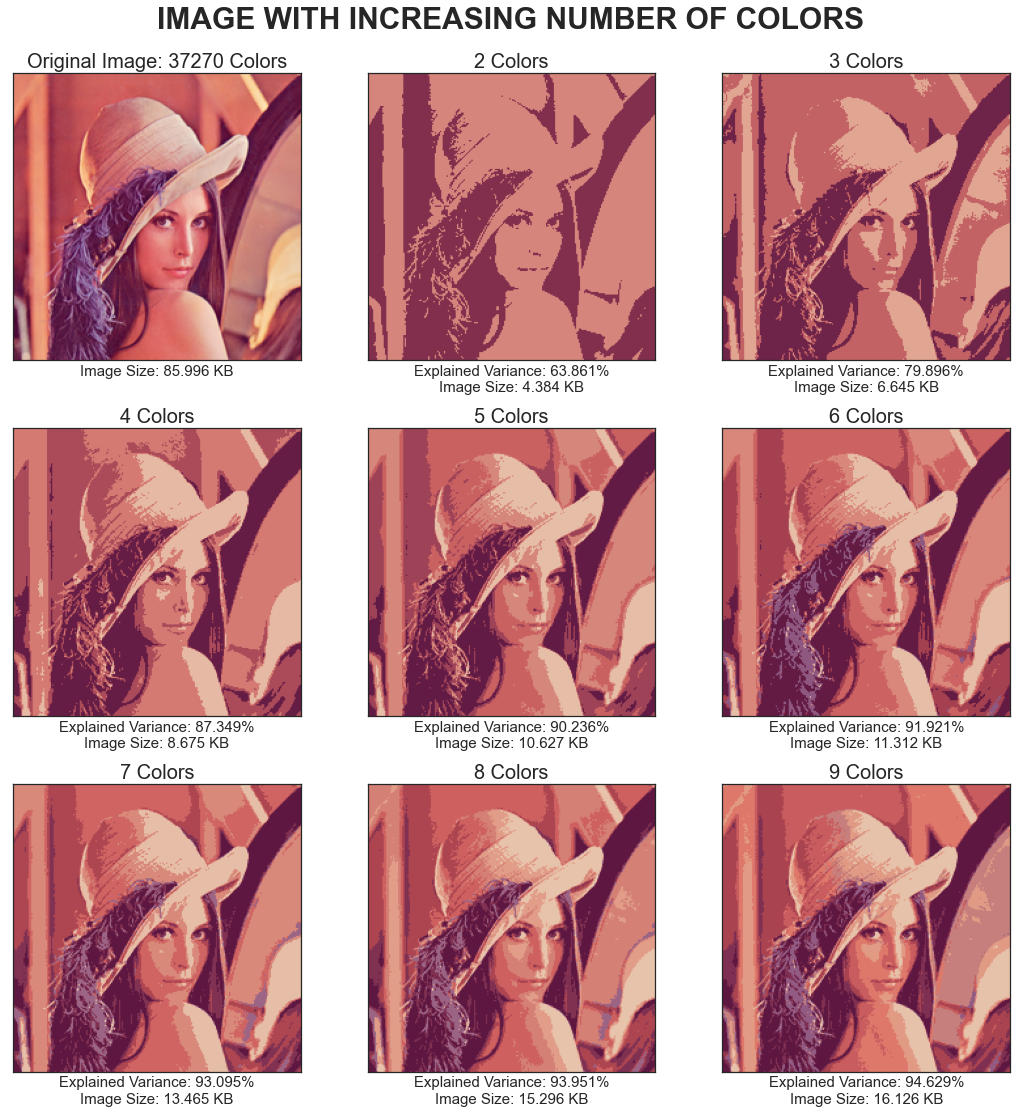

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))

# PLOT ORIGINAL IMAGE
axes[0][0].imshow(X.reshape(*ori_img.size, 3))
axes[0][0].set_title("Original Image: {} Colors".format(ori_img_n_colors), fontsize = 20)
axes[0][0].set_xlabel("Image Size: {:.3f} KB".format(ori_img_size), fontsize = 15)
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])

# PLOT COLOR-REDUCED IMAGE
for ax, k, pixels in zip(axes.flat[1:], kmeans_result.index, kmeans_result["Pixels"]):
    compressed_image = np.array(pixels/255).reshape(*ori_img.size, 3)
    ax.imshow(compressed_image)
    ax.set_title("{} Colors".format(k), fontsize=20)
    ax.set_xlabel("Explained Variance: {:.3f}%\nImage Size: {:.3f} KB".format(kmeans_result.loc[k, "Explained Variance"],
                                                                              kmeans_result.loc[k, "Image Size (KB)"]),
                  fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.suptitle("IMAGE WITH INCREASING NUMBER OF COLORS", size = 30, y = 1.03, fontweight = "bold")
plt.show()

### Choosing the optimal number of clusters

#### Plotting the evaluation parameters v/s number of clusters

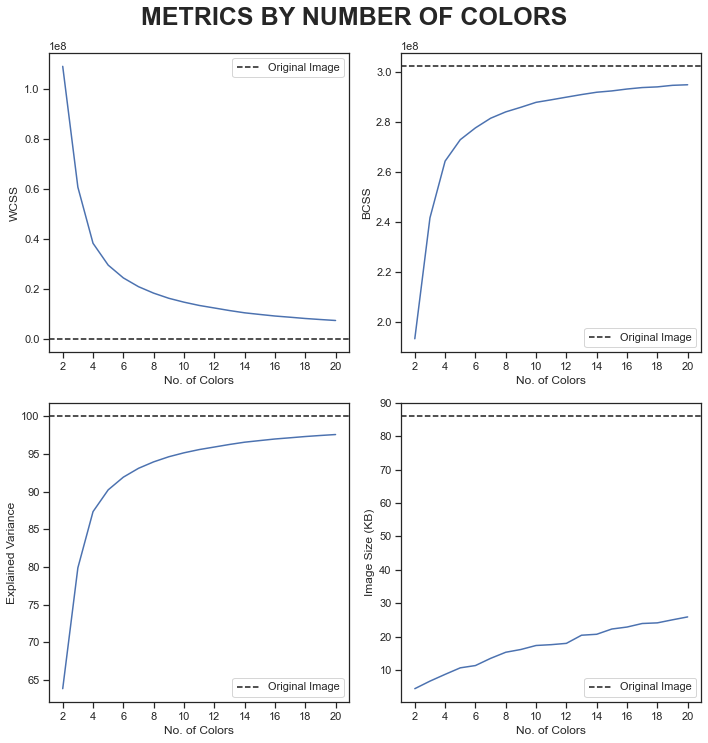

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for ax, metric in zip(axes.flat, kmeans_result.columns[2:]):
    sns.lineplot(x = kmeans_result.index, y = metric, data = kmeans_result, ax = ax)
    
    if metric == "WCSS":
        y_val = 0
    elif metric == "BCSS":
        y_val = ori_img_total_variance
    elif metric == "Explained Variance":
        y_val = 100
    elif metric == "Image Size (KB)":
        y_val = ori_img_size
    
    ax.axhline(y = y_val, color = 'k', linestyle = '--', label = "Original Image")
    ax.set_xticks(kmeans_result.index[::2])
    ax.ticklabel_format(useOffset = False)
    ax.legend()
plt.tight_layout()
fig.suptitle("METRICS BY NUMBER OF COLORS", size = 25, y = 1.03, fontweight = "bold")
plt.show()

The aim is to try and search for an optimal number of colors (clusters) k in order to reduce the memory size to be as small as possible while maintaining high explained variance percentage.

The first step in calculating the optimal number of clusters is to plot the evaluation parameter and the number of clusters.  
Two calculate optimal value for the number of clusters two methods can be used:
1. Elbow Method
    * The elbow method is used when the graph is either increasing or decreasing. The elbow method helps in locating the point that is furthest from the baseline value.
    
2. Local Drastic Change
    * In an event when the graph of the evaluation metric and the number of clusters is neither increasing or decreasing, then local drastic change in the graph is measured with the help of derivatives

In [16]:
# Getting optimal k with above-mentioned methods
optimal_k = []
for col in kmeans_result.columns[2:]:
    optimal_k_dict = {}
    optimal_k_dict["Metric"] = col
    if col == "Image Size (KB)":
        optimal_k_dict["Method"] = "Derivative"
        optimal_k_dict["Optimal k"] = locateDrasticChange(kmeans_result.index, kmeans_result[col].values)
    else:
        optimal_k_dict["Method"] = "Elbow"
        optimal_k_dict["Optimal k"] = locateOptimalElbow(kmeans_result.index, kmeans_result[col].values)
    optimal_k.append(optimal_k_dict)
optimal_k = pd.DataFrame(optimal_k)
optimal_k

,Metric,Method,Optimal k
0,WCSS,Elbow,5
1,BCSS,Elbow,5
2,Explained Variance,Elbow,5
3,Image Size (KB),Derivative,12


The largest optimal k is taken as the representative of all optimal k

In [18]:
k_opt = optimal_k["Optimal k"].max()
k_opt

12

### Comparision with Original Image

In [19]:
ori = {
    "Type": "Original",
    "Pixels": X,
    "No. of Colors": ori_img_n_colors,
    "Image Size (KB)": ori_img_size,
    "Explained Variance": 100
}
color_reduced = {
    "Type": "Color-Reduced",
    "Pixels": kmeans_result.loc[k_opt, "Pixels"],
    "No. of Colors": k_opt,
    "Image Size (KB)": kmeans_result.loc[k_opt, "Image Size (KB)"],
    "Explained Variance": kmeans_result.loc[k_opt, "Explained Variance"]
}
ori_vs_kmeans = pd.DataFrame([ori, color_reduced]).set_index("Type")
ori_vs_kmeans


,Pixels,No. of Colors,Image Size (KB),Explained Variance
Type,,,,
Original,"[[225, 137, 127], [224, 137, 127], [227, 134, ...",37270,85.996,100.000
Color-Reduced,"[[[231.94808510638322, 145.8660992907805, 119....",12,17.960,95.916


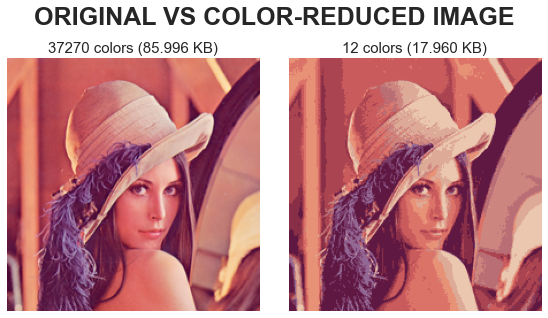

In [20]:
# Plotting the original and the compressed image side by side
fig, axes = plt.subplots(1, 2, figsize=(8,4))
for ax, (typ, row) in zip(axes.flat, ori_vs_kmeans.iterrows()):
    img_array = np.array(row["Pixels"]/255)
    ax.imshow(img_array.reshape(*ori_img.size, 3))
    ax.axis("off")
    ax.set_title("{} colors ({:.3f} KB)".format(row["No. of Colors"], row["Image Size (KB)"]), fontsize=15)
plt.tight_layout()
fig.suptitle("ORIGINAL VS COLOR-REDUCED IMAGE", size = 25, y = 1.1, fontweight = "bold")
plt.show()

In [21]:
relative_size = ori_vs_kmeans.loc["Color-Reduced", "Image Size (KB)"]/ori_vs_kmeans.loc["Original", "Image Size (KB)"]
print("Reduction: {:.3f}% from original image size".format((1-relative_size)*100))
print("Explained Variance: {:.3f}%".format(ori_vs_kmeans.loc["Color-Reduced", "Explained Variance"]))

Reduction: 79.115% from original image size
Explained Variance: 95.916%


By using K-Means, significant reduction of 79.012% in the image size is achieved and 95.916% variance of original image is explained by the compressed image.